- Iris: https://www.kaggle.com/hammadzahidali/comparing-classification-models-sklearn-iris-data
- Regression: https://www.kaggle.com/eikedehling/comparing-models-xgb-lgb-rf-and-stacking

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_colwidth = 100

import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection

####################################################### Classifiers models
from sklearn.linear_model   import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.svm            import SVC, NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost                import XGBClassifier
from catboost               import CatBoostClassifier
from lightgbm               import LGBMClassifier

from sklearn.naive_bayes           import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

####################################################### Regressors models
from sklearn.linear_model   import Ridge, Lasso
from sklearn.neighbors      import KNeighborsRegressor
from sklearn.tree           import DecisionTreeRegressor
from sklearn.ensemble       import RandomForestRegressor
from xgboost.sklearn        import XGBRegressor
from lightgbm.sklearn       import LGBMRegressor
from catboost               import CatBoostRegressor

# Datasets

In [2]:
####################################################### Classification datasets
iris      = datasets.load_iris()
digits    = datasets.load_digits()          # 8x8 bitmaps of handwritten digits
wine      = datasets.load_wine()
wisconsin = datasets.load_breast_cancer()   #  breast cancer wisconsin dataset (classification)

####################################################### Regression datasets
boston    = datasets.load_boston()          # boston house-prices dataset (regression).
diabetes  = datasets.load_diabetes()
linnerud  = datasets.load_linnerud()        # linnerud dataset (multivariate regression).

# Models

In [3]:
num_trees=20

####################################################### Classifiers models
clasiffiers = [
    LogisticRegression(solver='lbfgs', multi_class="multinomial", max_iter=200),
    KNeighborsClassifier(n_neighbors=5),
    SVC(kernel="rbf", gamma="auto"), # (gamma=2, C=1)
    MLPClassifier(alpha=1, learning_rate_init=0.01),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    NuSVC(probability=True),
    DecisionTreeClassifier(),                            # max_depth=5
    RandomForestClassifier(n_estimators=num_trees),      # max_depth=5, max_features=1
    AdaBoostClassifier(n_estimators=num_trees),          #
    GradientBoostingClassifier(n_estimators=num_trees),
    XGBClassifier(n_estimators=num_trees),
    LGBMClassifier(n_estimators=num_trees)
]

####################################################### Regressors models
regressors = [
    Ridge(alpha=75.0),
    Lasso(alpha=0.75),
    KNeighborsRegressor(n_neighbors=25, weights='distance'),
    DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25),
    RandomForestRegressor(n_estimators=25, min_samples_leaf=25, min_samples_split=25),
    XGBRegressor(n_estimators=150, objective='reg:linear', subsample=0.75),
    LGBMRegressor(n_estimators=150, subsample=0.85, subsample_freq=5, learning_rate=0.05),
    CatBoostRegressor(iterations=150)
]

Cheack https://jonathonbechtel.com/blog/2018/02/06/wines/


In [30]:
classifiers_with_params = {
    "Logistic Regression": {'classifier': LogisticRegression(),
                            'params': [{"solver": ['lbfgs'], "multi_class": ["multinomial"],
                                        "max_iter": [200]}]},
                            #'params': [{'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}]},
    
    "Nearest Neighbors": {'classifier': KNeighborsClassifier(),
                          'params': [{'n_neighbors': [1, 3, 5, 10], 'leaf_size': [3, 30]}]},
    
    #"SVM (linear)":      {'classifier': SVC(),
    #                      'params': [{'C': [1, 10, 100, 1000], 'gamma': ["auto", 0.001, 0.0001], 'kernel': ['linear']}]},
    
    "SVM (rbf)":         {'classifier': SVC(),
                          'params': [{'C': [1, 10, 100, 1000], 'gamma': ["auto", 0.001, 0.0001], 'kernel': ['rbf']}]},
    
    "Neural network":    {'classifier': MLPClassifier(),
                          'params': [{'alpha': [1], 'learning_rate_init': [0.01]}]},
    
    "Naive Bayes":       {'classifier': GaussianNB(),
                          'params': {}},
    
    "Decision Tree":     {'classifier': DecisionTreeClassifier(),
                          'params': [{'max_depth':[3, None]}]},
    
    "Random Forest":     {'classifier': RandomForestClassifier(),
                          'params': [{'n_estimators' :[10, 20, 50, 100]}]},
    
    "Adaboost":          {'classifier': AdaBoostClassifier(),
                          'params': [{'n_estimators' :[10, 20, 50, 100]}]},
    
    "Gradient Boosting (Sklearn)":  {'classifier': GradientBoostingClassifier(),
                                     'params': [{'learning_rate': [0.05, 0.1],
                                                 'n_estimators' : [10, 20, 50, 100],
                                                 'max_depth':     [3, 5, None]}]},
    
    "Gradient Boosting (XGBoost)":  {'classifier': XGBClassifier(),
                                     'params': [{'learning_rate': [0.05, 0.1],
                                                 'n_estimators' : [10, 20, 50, 100],
                                                 'max_depth':     [3, 5, 7],
                                                 'n_jobs':        [4]}]},
    
    "Gradient Boosting (LightGBM)": {'classifier': LGBMClassifier(),
                                     'params': [{'learning_rate': [0.01, 0.05, 0.1],
                                                 'n_estimators' : [10, 20, 50, 100],
                                                 'num_leaves':    [8, 16, 32, 64]}]},
}

# Search and train

# Train
Train each model with 10-fold CV

In [31]:
def compare(dataset, folds=10):
    x  = dataset.data
    y  = dataset.target
    #cv = model_selection.StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)

    cols   = ["Classifier", "Accuracy" , "Best params"]
    accuracies = pd.DataFrame(columns=cols)

    estimator = 0
    for name, classifier in classifiers_with_params.items():

        print(name, "...")
        grid = model_selection.GridSearchCV(classifier['classifier'],
                                            classifier['params'],
                                            cv=folds, scoring='accuracy', n_jobs=-1)
        estimator = grid.fit(x, y)

        print('\tBest score:     ', grid.best_score_)
        print('\tBest parameters:', grid.best_params_)
        #print('Best model:     ', grid.best_estimator_)

        accuracies = accuracies.append(pd.DataFrame([[name, grid.best_score_*100, grid.best_params_]], columns=cols))    

    return accuracies

def compare_old(dataset, folds=10):
    x = dataset.data
    y = dataset.target
    
    kfold   = model_selection.StratifiedKFold(n_splits=folds, shuffle=True, random_state=0) # KFold
    
    cols = ["Classifier", "Fold", "Accuracy"]
    accuracies = pd.DataFrame(columns=cols)
    print("Accuracies:\n")
    for model in clasiffiers:
        name = model.__class__.__name__
        cv_acc = model_selection.cross_val_score(model, x, y, cv=kfold, scoring="accuracy", n_jobs=-1)

        for i in range(folds):
            accuracies = accuracies.append(pd.DataFrame([[name, i, cv_acc[i]*100]], columns=cols))

        print("\t%s:\t%f (%f)" % (name, cv_acc.mean(), cv_acc.std()))
    
    return accuracies

def plot(accuracies, min=80):
    sns.set_color_codes("muted")
    plt.figure(figsize=(14, 6))
    #sns.barplot(x='Accuracy', y='Classifier', data=accuracies, capsize=.2, color="b",)
    sns.barplot(x='Accuracy', y='Classifier', data=accuracies, capsize=.2, palette=["b"]*5+["g"]*2+["y"]*4)
    
    plt.xlim((min, 100))
    plt.xlabel('Accuracy %')
    plt.title('Classifier Accuracy')
    plt.show()

# Dataset iris
![iris img](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Machine+Learning+R/iris-machinelearning.png)

In [38]:
#accuracies = compare(iris, folds=10)
accuracies

,Classifier,Accuracy,Best params
0,Logistic Regression,97.333333,"{'max_iter': 200, 'multi_class': 'multinomial', 'solver': 'lbfgs'}"
0,Nearest Neighbors,96.666667,"{'leaf_size': 3, 'n_neighbors': 3}"
0,SVM (rbf),98.000000,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}"
0,Neural network,98.666667,"{'alpha': 1, 'learning_rate_init': 0.01}"
0,Naive Bayes,95.333333,{}
0,Decision Tree,96.000000,{'max_depth': 3}
0,Random Forest,96.666667,{'n_estimators': 20}
0,Adaboost,95.333333,{'n_estimators': 10}
0,Gradient Boosting (Sklearn),96.000000,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 10}"
0,Gradient Boosting (XGBoost),96.666667,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 10, 'n_jobs': 4}"


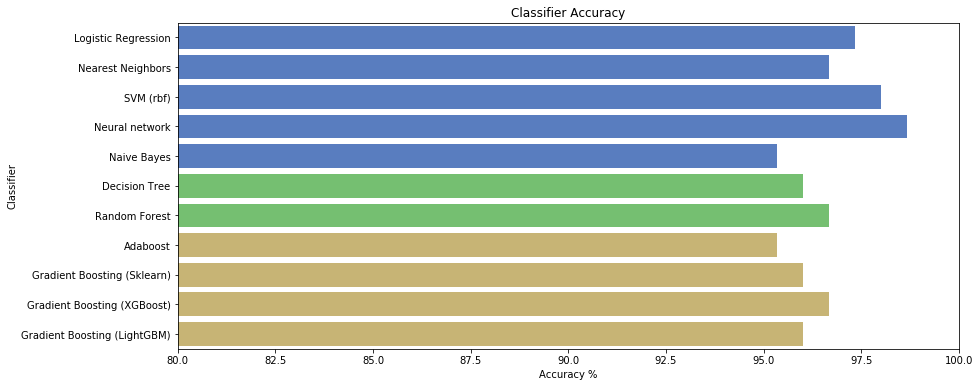

In [39]:
plot(accuracies)

# Dataset Wisconsin

In [33]:
accuracies = compare(wisconsin, folds=10)
accuracies

,Classifier,Accuracy,Best params
0,Logistic Regression,95.606327,"{'max_iter': 200, 'multi_class': 'multinomial', 'solver': 'lbfgs'}"
0,Nearest Neighbors,93.145870,"{'leaf_size': 3, 'n_neighbors': 10}"
0,SVM (rbf),94.200351,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}"
0,Neural network,92.267135,"{'alpha': 1, 'learning_rate_init': 0.01}"
0,Naive Bayes,93.848858,{}
0,Decision Tree,91.388401,{'max_depth': None}
0,Random Forest,96.309315,{'n_estimators': 100}
0,Adaboost,97.539543,{'n_estimators': 100}
0,Gradient Boosting (sklearn),96.309315,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}"
0,Gradient Boosting (XGBoost),96.836555,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'n_jobs': 4}"


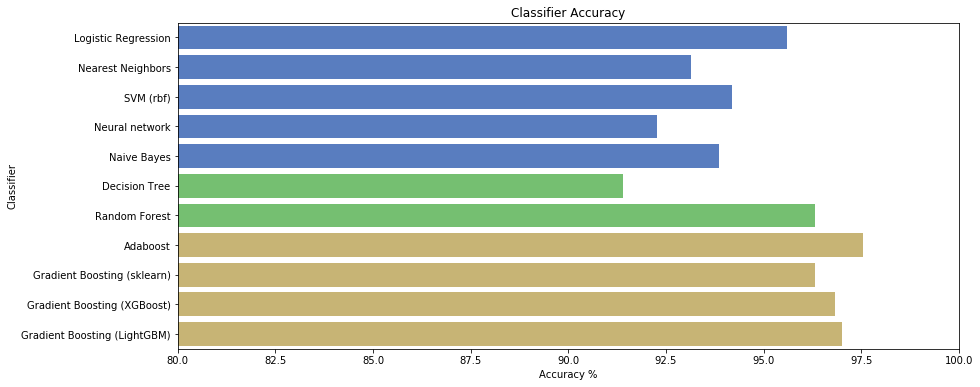

In [32]:
plot(accuracies)

# Dataset NIST
![img](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

In [42]:
accuracies = compare(digits, folds=10)
accuracies

,Classifier,Accuracy,Best params
0,Logistic Regression,92.932666,"{'max_iter': 200, 'multi_class': 'multinomial', 'solver': 'lbfgs'}"
0,Nearest Neighbors,97.774068,"{'leaf_size': 3, 'n_neighbors': 3}"
0,SVM (rbf),98.107958,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}"
0,Neural network,95.047301,"{'alpha': 1, 'learning_rate_init': 0.01}"
0,Naive Bayes,81.023929,{}
0,Decision Tree,82.637730,{'max_depth': None}
0,Random Forest,95.381191,{'n_estimators': 100}
0,Adaboost,27.045075,{'n_estimators': 10}
0,Gradient Boosting (Sklearn),93.433500,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}"
0,Gradient Boosting (XGBoost),93.711742,"{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 4}"


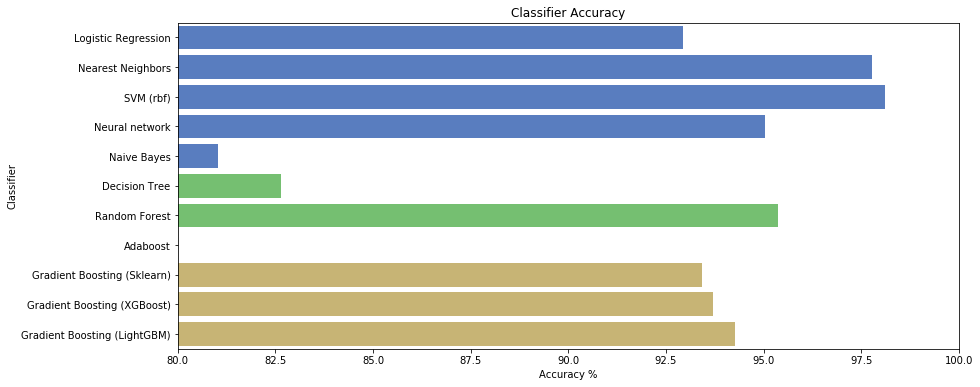

In [41]:
plot(accuracies)